# Absenteeism Analysis - Group 10

## <b>1.0 Introduction</b>

Welcome to Group 10's Data Mining I Project.
Our group consists of the following members:

Fariha Khan (20250291) <br/>
Tyler Johnston (20250903) <br/>
Zara <br/>
Victory <br/>

### 1.1: Project Purpose

A courier company in Brazil has concerns with the rising growth of absenteeism among its employees. They wish to answer the following question: "Why are they (our employees) not here today?"

This company has provided anonymized data on employee demographics, work conditions, and absence records. Now, in this project, we aim to utilize this information to uncover why employees are usually absent using Data Mining (clustering) techniques.

### 1.2: Project Set-up

In [79]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)
import warnings
warnings.filterwarnings('ignore')

# constants
NUM_OF_DASHES = 60

# configure visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

# configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

## <b>2.0: Data Exploration</b>

Goals:
- To gain understanding in each feature (especially as they relate to absenteeism)
- To detect data quality issues (missing values, skewness, outliers) before preprocessing
- To identify patterns that can be used for clustering

### 2.1: Description of Data Received

In [30]:
df = pd.read_csv('absenteeism_data.csv', sep=';')

print(f"Total Records: {df.shape[0]} employees")
print(f"Total Features: {df.shape[1]} variables")

df.head()

Total Records: 800 employees
Total Features: 22 variables


,ID,Reason for absence,Month of absence,Day of the week,Seasons,Days since previous absence,Transportation expense,Distance from Residence to Work,Estimated commute time,Service time,Years until retirement,Date of Birth,Disciplinary failure,Education,Number of children,Social drinker,Social smoker,Number of pets,Weight,Height,Body mass index,Absenteeism time in hours
0,11,Unjustified absence,July,Tuesday,Summer,0.00,289,36,69,13,32,1992-08-15,No,1,2,Y,No,1,90,172,30,4
1,36,Unspecified,July,Tuesday,NaN,0.00,118,13,26,18,15,1975-09-02,Yes,1,1,Y,No,0,98,178,31,0
2,3,Medical consultation,July,Wednesday,Summer,0.00,179,51,108,18,27,1987-04-08,No,1,0,Yes,No,0,89,170,31,2
3,7,Diseases of the eye and adnexa,July,Thursday,NaN,0.00,279,5,5,14,26,1986-07-25,No,1,2,Yes,Yes,0,68,168,24,4
4,11,Medical consultation,July,Thursday,Summer,0.00,289,36,69,13,32,1992-08-15,No,1,2,Yes,No,1,90,172,30,2


In [31]:
print("\n" + "-" * NUM_OF_DASHES)
print("Dataset Column Information")
print("-" * NUM_OF_DASHES)
df.dtypes.to_frame("dtype").assign(non_null=df.notna().sum())


------------------------------------------------------------
Dataset Column Information
------------------------------------------------------------


,dtype,non_null
ID,int64,800
Reason for absence,object,740
Month of absence,object,737
Day of the week,object,740
Seasons,object,573
Days since previous absence,float64,781
Transportation expense,int64,800
Distance from Residence to Work,int64,800
Estimated commute time,int64,800
Service time,object,800


In [32]:
print("\n" + "-" * NUM_OF_DASHES)
print("Missing Values Analysis")
print("-" * NUM_OF_DASHES)
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_data,
    'Percentage': missing_percent
}).sort_values('Missing_Count', ascending=False)
missing_df[missing_df['Missing_Count'] > 0]


------------------------------------------------------------
Missing Values Analysis
------------------------------------------------------------


,Missing_Count,Percentage
Seasons,227,28.38
Month of absence,63,7.88
Day of the week,60,7.50
Reason for absence,60,7.50
Days since previous absence,19,2.38


### 2.2: Statistical Summary

In [33]:
print("\n" + "-"*NUM_OF_DASHES)
print("Feature Statistical Analysis")
print("-"*NUM_OF_DASHES)
stats_summary = df.select_dtypes(include="number").drop(columns=["ID"]).describe()
stats_summary


------------------------------------------------------------
Feature Statistical Analysis
------------------------------------------------------------


,Days since previous absence,Transportation expense,Distance from Residence to Work,Estimated commute time,Years until retirement,Education,Number of children,Number of pets,Height,Body mass index,Absenteeism time in hours
count,781.00,800.00,800.00,800.00,800.00,800.00,800.00,800.00,800.00,800.00,800.00
mean,0.00,221.93,29.80,59.35,26.74,1.29,1.04,0.74,172.09,26.64,7.09
std,0.00,66.78,14.88,31.30,9.27,0.67,1.12,1.32,6.06,4.27,13.95
min,0.00,118.00,5.00,5.00,-1.00,1.00,0.00,0.00,163.00,19.00,0.00
25%,0.00,179.00,16.00,31.00,25.00,1.00,0.00,0.00,169.00,24.00,2.00
50%,0.00,225.00,26.00,52.00,28.00,1.00,1.00,0.00,170.00,25.00,3.00
75%,0.00,260.00,50.00,94.00,33.00,1.00,2.00,1.00,172.00,31.00,8.00
max,0.00,388.00,52.00,114.00,38.00,4.00,4.00,8.00,196.00,38.00,120.00


In [34]:
print("\n" + "-"*NUM_OF_DASHES)
print("Skewness, Kurtosis, and IQR")
print("-"*NUM_OF_DASHES)

numerical_df = df.select_dtypes(include="number").drop(columns=["ID"])
additional_stats = pd.DataFrame({
    'Skewness': numerical_df.skew(),
    'Kurtosis': numerical_df.kurtosis(),
    'IQR': numerical_df.quantile(0.75) - numerical_df.quantile(0.25)
})
additional_stats


------------------------------------------------------------
Skewness, Kurtosis, and IQR
------------------------------------------------------------


,Skewness,Kurtosis,IQR
Days since previous absence,0.00,0.00,0.00
Transportation expense,0.39,-0.32,81.00
Distance from Residence to Work,0.30,-1.28,34.00
Estimated commute time,0.47,-1.13,63.00
Years until retirement,-1.49,2.28,8.00
Education,2.13,3.07,0.00
Number of children,1.07,0.66,2.00
Number of pets,2.76,9.82,1.00
Height,2.58,7.37,3.00
Body mass index,0.32,-0.32,7.00


### 2.3: Numerical Feature Analysis


------------------------------------------------------------
Analyze Absenteeism Time in Hours
------------------------------------------------------------


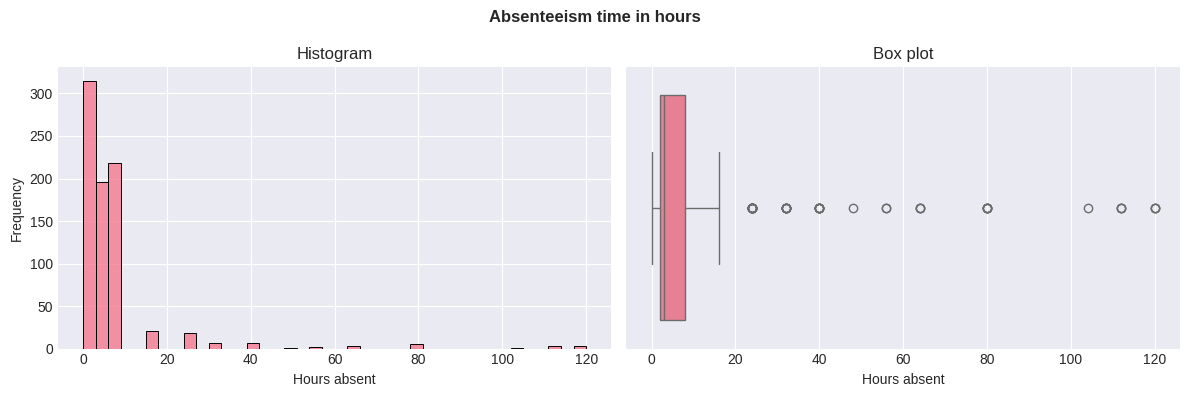

In [35]:
print("\n" + "-"*NUM_OF_DASHES)
print("Analyze Absenteeism Time in Hours")
print("-"*NUM_OF_DASHES)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(df["Absenteeism time in hours"], bins=40)
plt.xlabel("Hours absent")
plt.ylabel("Frequency")
plt.title("Histogram")

plt.subplot(1, 2, 2)
sns.boxplot(x=df["Absenteeism time in hours"])
plt.xlabel("Hours absent")
plt.title("Box plot")

plt.suptitle("Absenteeism time in hours", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()



------------------------------------------------------------
Analyze Discrete Features
------------------------------------------------------------


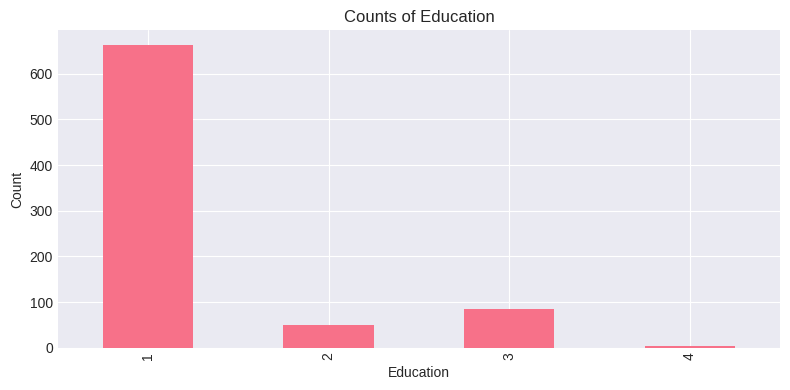

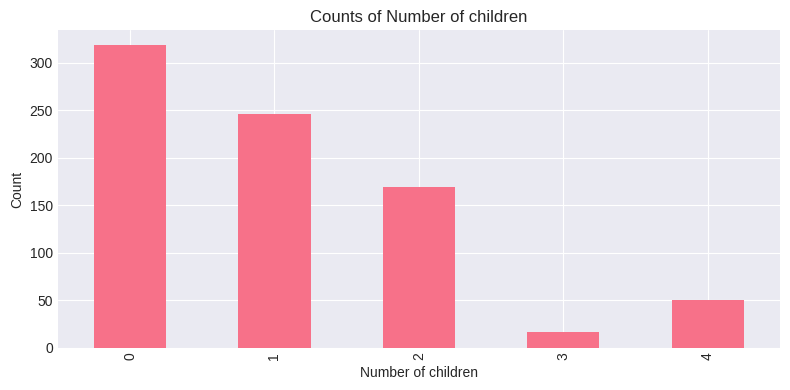

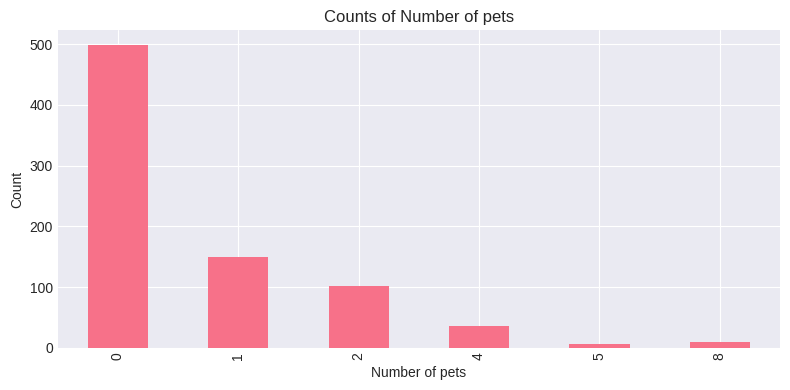

In [36]:
print("\n" + "-"*NUM_OF_DASHES)
print("Analyze Discrete Features")
print("-"*NUM_OF_DASHES)

discrete_features = ["Education", "Number of children", "Number of pets"]

for feature in discrete_features:
    plt.figure(figsize=(8, 4))
    df[feature].value_counts().sort_index().plot(kind="bar")
    plt.title(f"Counts of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


------------------------------------------------------------
Analyze Continuous Features
------------------------------------------------------------


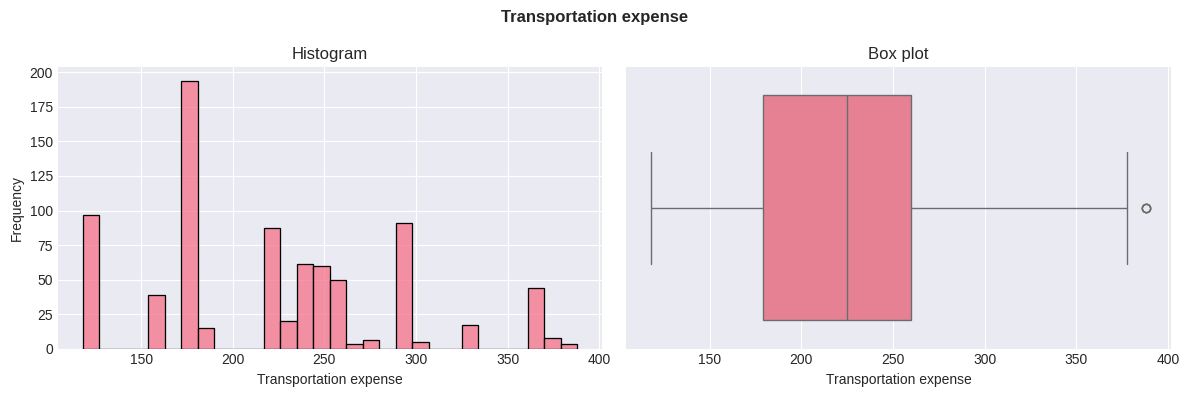

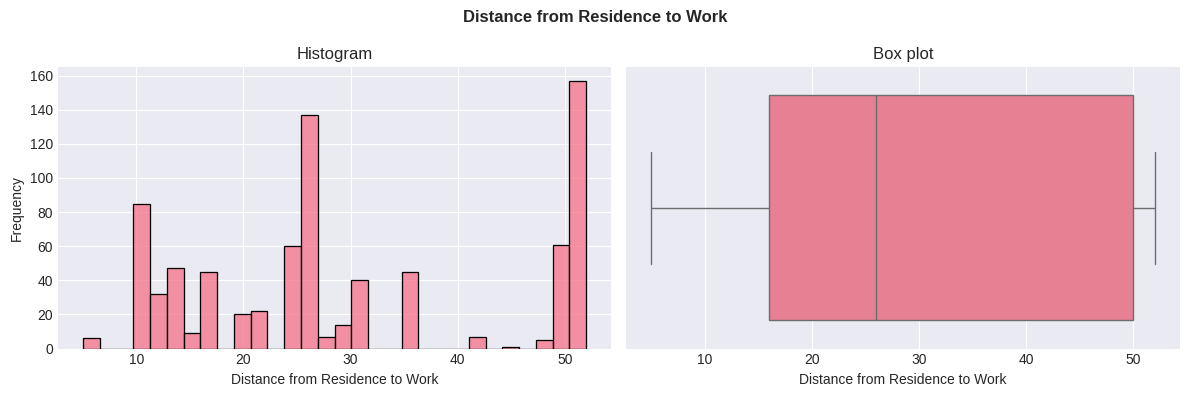

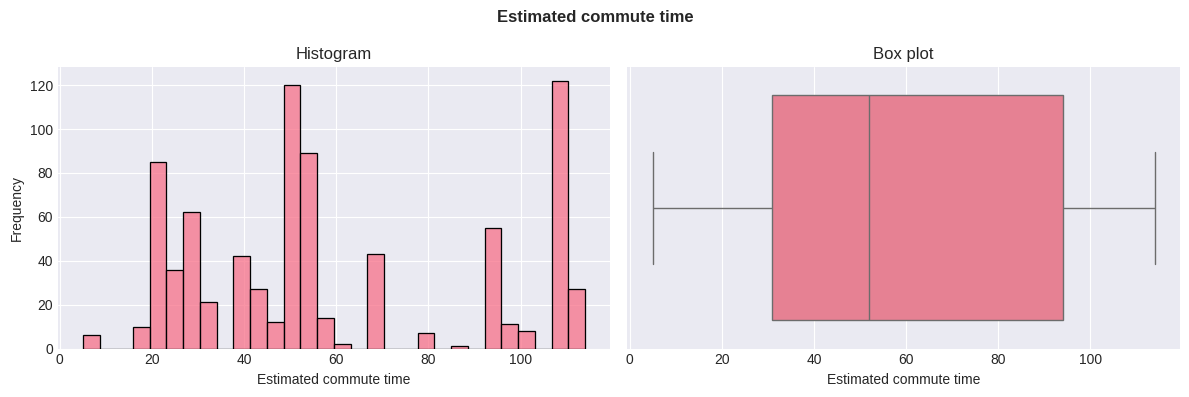

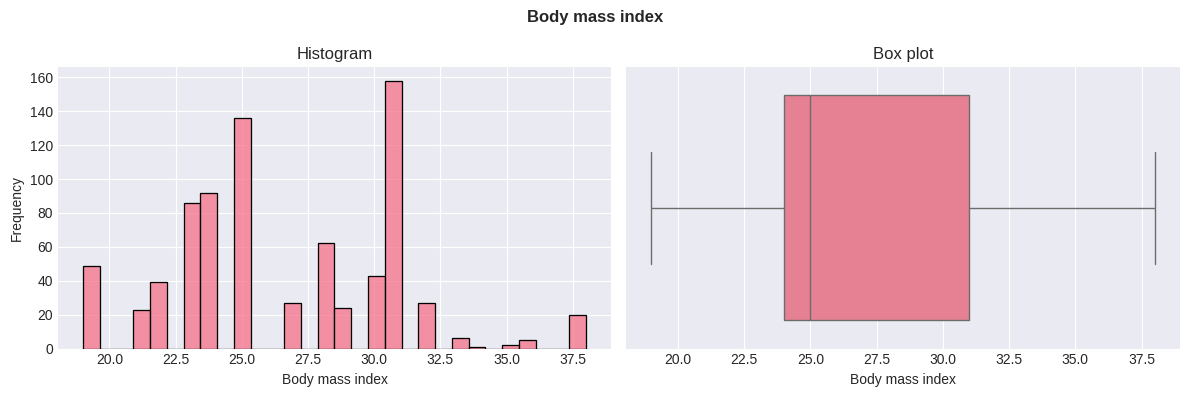

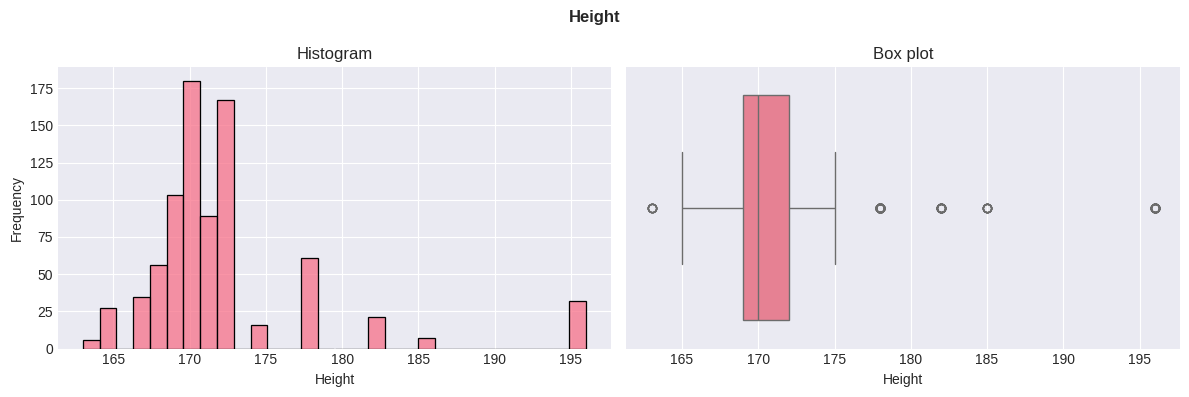

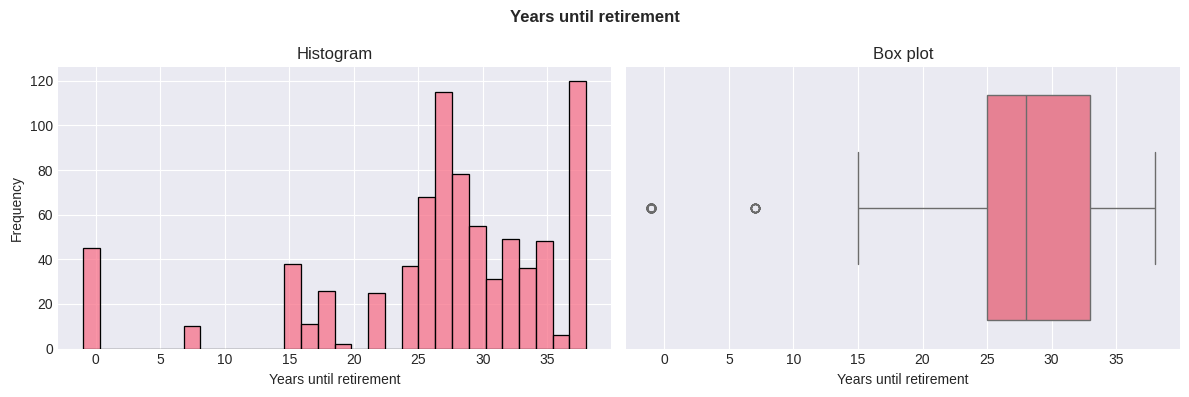

In [37]:
print("\n" + "-" * NUM_OF_DASHES)
print("Analyze Continuous Features")
print("-" * NUM_OF_DASHES)

continuous_features = [
    "Transportation expense",
    "Distance from Residence to Work",
    "Estimated commute time",
    "Body mass index",
    "Height",
    "Years until retirement",
]

for feature in continuous_features:
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(df[feature], bins=30)
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.title("Histogram")

    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[feature])
    plt.xlabel(feature)
    plt.title("Box plot")

    plt.suptitle(f"{feature}", fontsize=12, fontweight="bold")
    plt.tight_layout()
    plt.show()



------------------------------------------------------------
Absenteeism vs Potential Drivers
------------------------------------------------------------


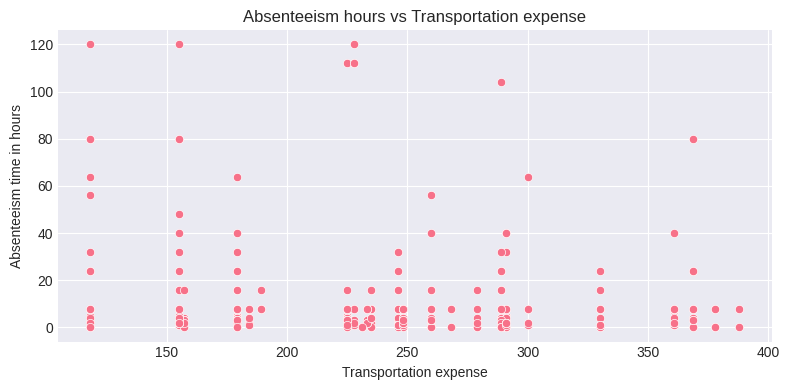

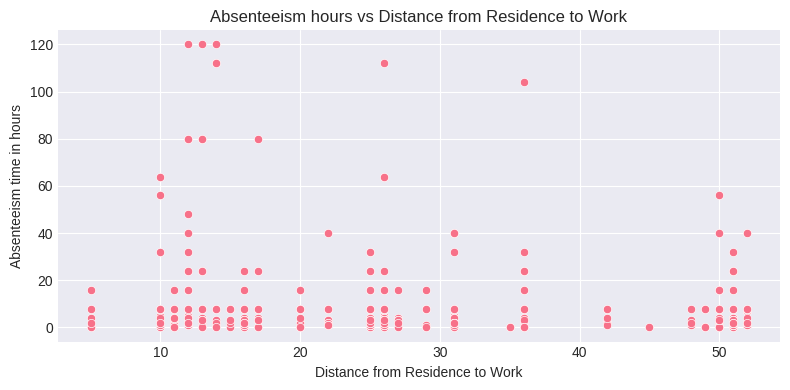

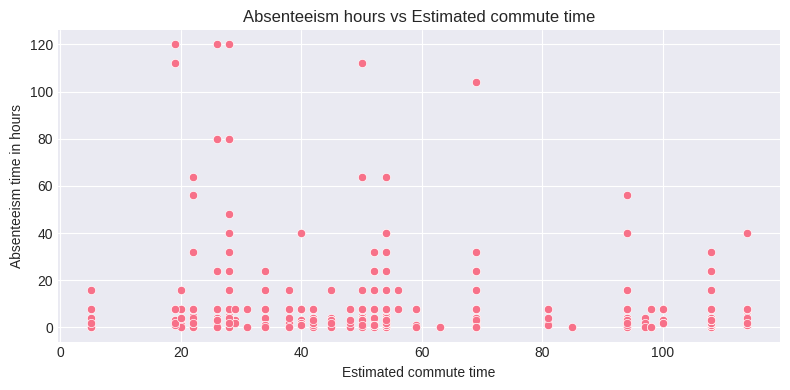

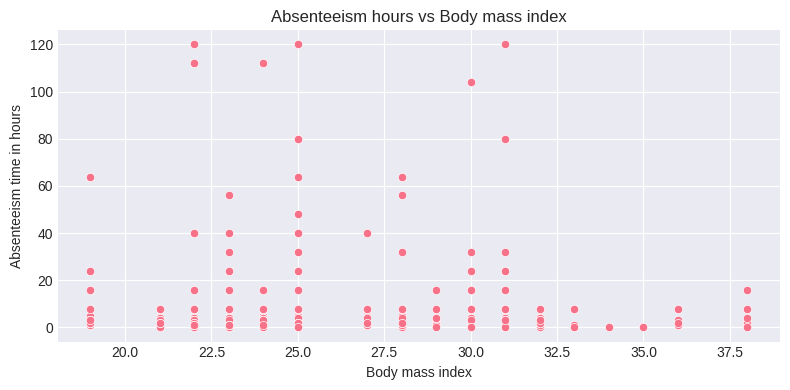

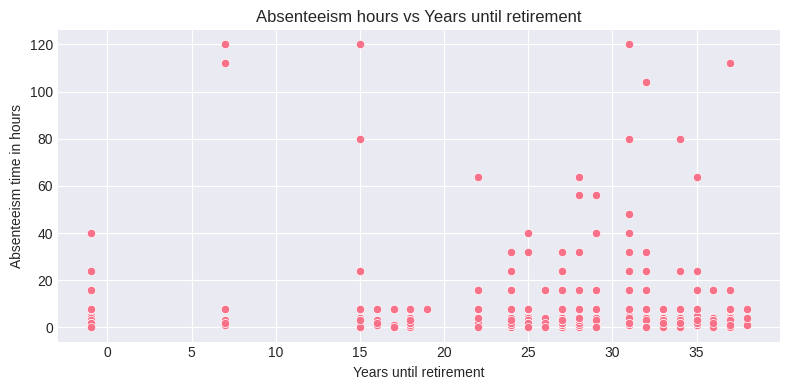

In [38]:
print("\n" + "-" * NUM_OF_DASHES)
print("Absenteeism vs Potential Drivers")
print("-" * NUM_OF_DASHES)

potential_drivers = [
    "Transportation expense",
    "Distance from Residence to Work",
    "Estimated commute time",
    "Body mass index",
    "Years until retirement",
]

for driver in potential_drivers:
    plt.figure(figsize=(8, 4))
    sns.scatterplot(x=df[driver], y=df["Absenteeism time in hours"])
    plt.title(f"Absenteeism hours vs {driver}")
    plt.xlabel(driver)
    plt.ylabel("Absenteeism time in hours")
    plt.tight_layout()
    plt.show()



------------------------------------------------------------
Correlation Matrix
------------------------------------------------------------


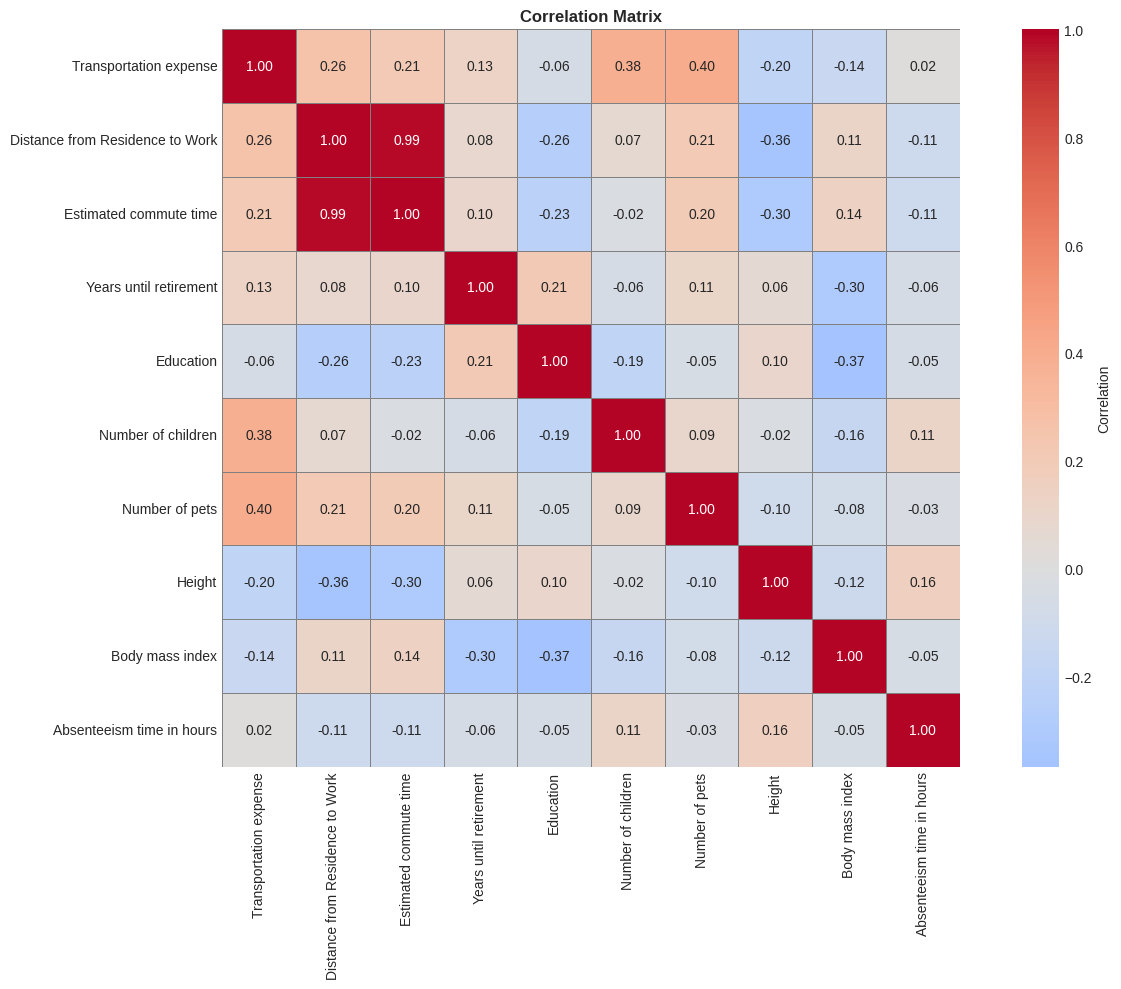

In [57]:
print("\n" + "-" * NUM_OF_DASHES)
print("Correlation Matrix")
print("-" * NUM_OF_DASHES)

numerical_df = df.select_dtypes(include="number").drop(columns=["ID", "Days since previous absence"])
corr_matrix = numerical_df.corr()

plt.figure(figsize=(14, 10))

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    square=True,
    cbar_kws={'label': 'Correlation'},
    linewidths=0.5,
    linecolor='gray'
)

plt.title('Correlation Matrix', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# NOTES:
# We need to remove the ID col in this analysis because it isn´t relevant
# Also, the "Days since previous absence" column only has zeroes, making it useless (so I also dropped this one)


### 2.5: Categorical Features Analysis


------------------------------------------------------------
Visual Analysis of Key Categorical Features
------------------------------------------------------------


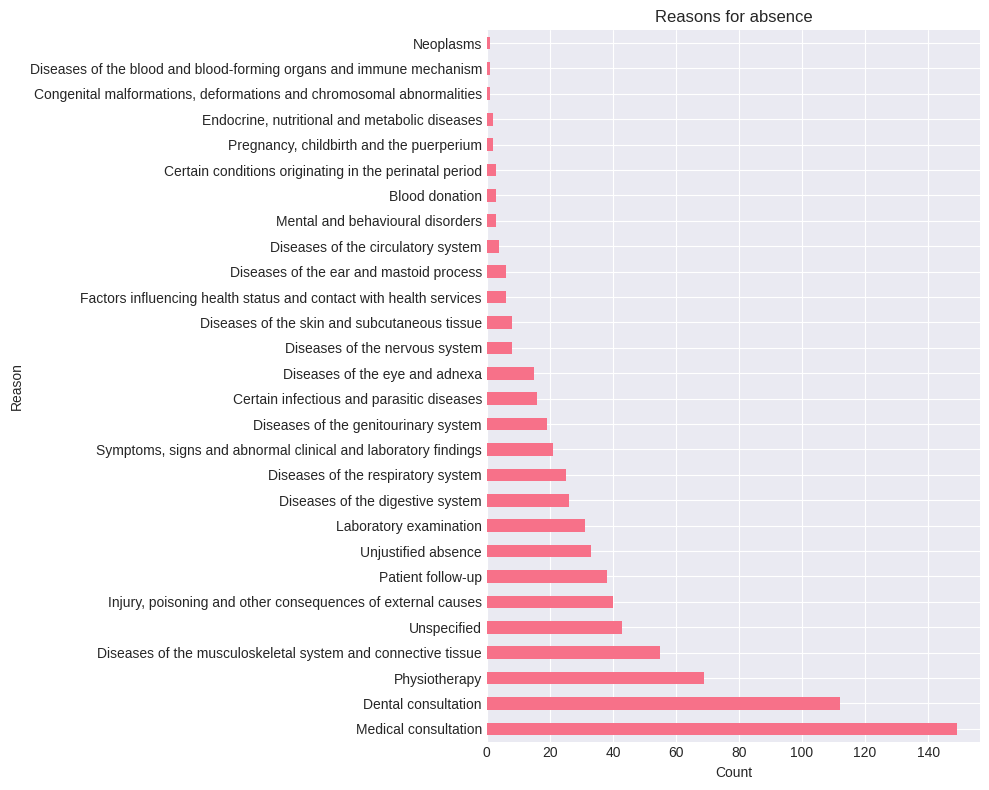

In [81]:
print("\n" + "-"*NUM_OF_DASHES)
print("Visual Analysis of Key Categorical Features")
print("-"*NUM_OF_DASHES)

plt.figure(figsize=(10, 8))
reason_counts = df["Reason for absence"].value_counts()
reason_counts.plot(kind="barh")
plt.title("Reasons for absence")
plt.xlabel("Count")
plt.ylabel("Reason")
plt.tight_layout()
plt.show()


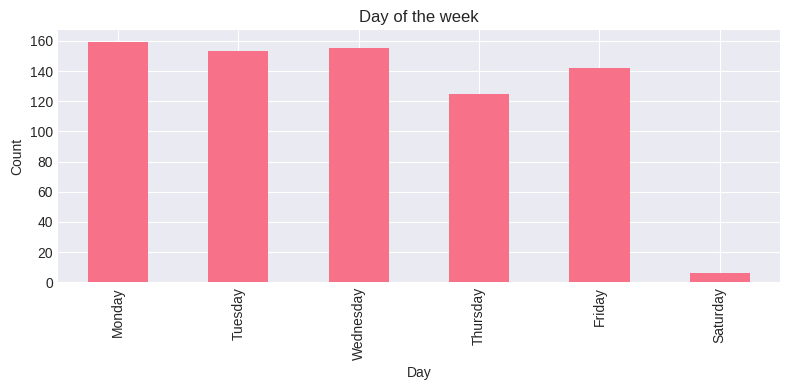

In [82]:
plt.figure(figsize=(8, 4))

day_order = ["Monday", "Tuesday", "Wednesday", "Thursday",
             "Friday", "Saturday", "Sunday"]

day_counts = df["Day of the week"].value_counts()
day_counts = day_counts.reindex([d for d in day_order if d in day_counts.index])

day_counts.plot(kind="bar")
plt.title("Day of the week")
plt.xlabel("Day")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

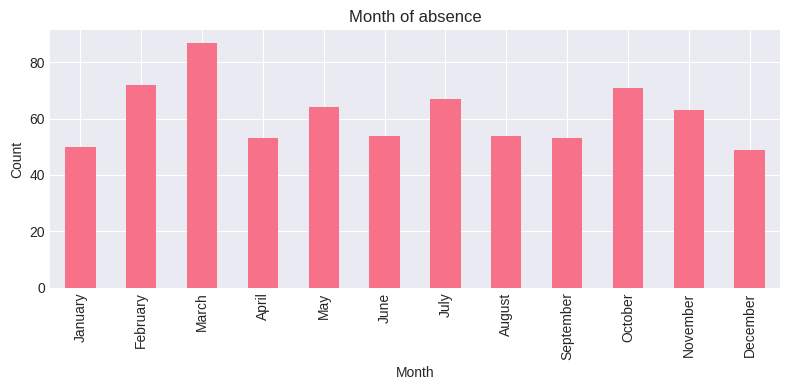

In [83]:
plt.figure(figsize=(8, 4))

month_order = ["January", "February", "March", "April", "May", "June",
               "July", "August", "September", "October", "November", "December"]

month_counts = df["Month of absence"].value_counts()
month_counts = month_counts.reindex([m for m in month_order if m in month_counts.index])

month_counts.plot(kind="bar")
plt.title("Month of absence")
plt.xlabel("Month")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

### 2.6: Age Analysis


------------------------------------------------------------
Age Analysis
------------------------------------------------------------


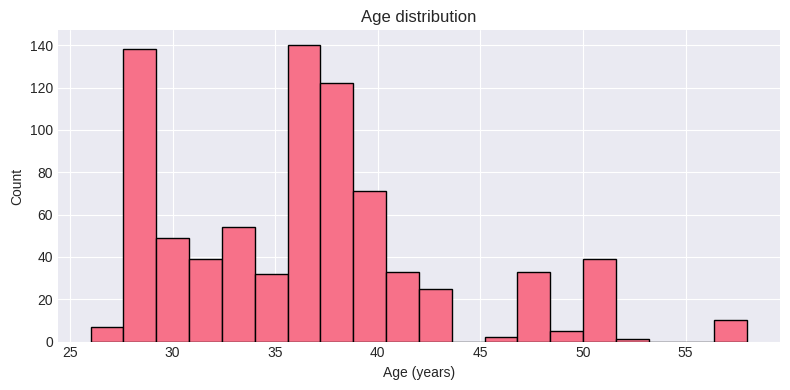

In [ ]:
print("\n" + "-"*NUM_OF_DASHES)
print("Age Analysis")
print("-"*NUM_OF_DASHES)

today = datetime.today()
df["Age"] = (today - pd.to_datetime(df["Date of Birth"])).dt.days // 365

plt.figure(figsize=(8, 4))
df["Age"].hist(bins=20, edgecolor="black")
plt.title("Age distribution")
plt.xlabel("Age (years)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# I am using today's date to compare their Date of Birth with to calculate age.
# This implies the employee ages I am analyzing will be different from when the data was collected.

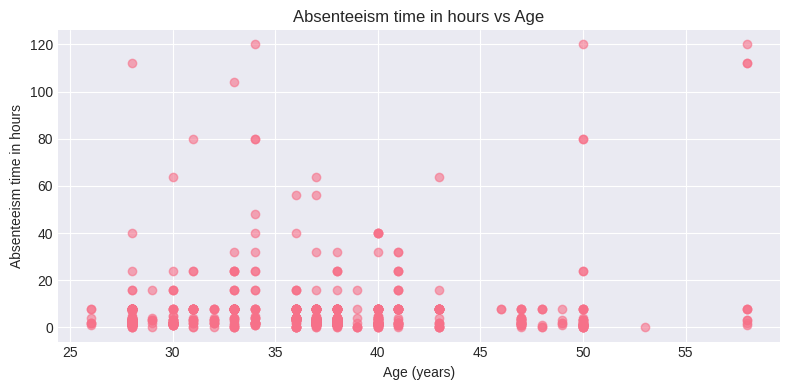

In [86]:
plt.figure(figsize=(8, 4))
plt.scatter(df["Age"], df["Absenteeism time in hours"], alpha=0.6)
plt.title("Absenteeism time in hours vs Age")
plt.xlabel("Age (years)")
plt.ylabel("Absenteeism time in hours")
plt.tight_layout()
plt.show()

<b>Data Exploration Key Insights</b>

- Absenteeism time in hours is highly right-skewed with many short absences and a few extreme long ones (up to 120 hours)
- Commute-related variables (distance, estimated time, transportation expense) are moderately correlated with each other but only weakly with absenteeism
- Most absences are justified (e.g., medical or dental consultations), with a smaller share due to unspecified or disciplinary reasons
- Absences are more frequent on weekdays (especially Monday–Wednesday) and are relatively balanced across seasons and months, with some peaks in late winter/early spring
- Most employees are young to mid-career, and age appears to have only a weak relationship with absenteeism, with no clear high-absence age group
- Several features show data quality issues (constant or near-constant values, inconsistent labels like `Y` vs `Yes`, and placeholder values in weight), motivating cleaning and possible feature removal

## <b>3.0: Data Pre-Processing</b>

### 3.1: Feature Engineering

In [41]:
df_prep = df.copy()

print("\n[1] Feature Engineering")
print("-"*NUM_OF_DASHES)

# Calculate age from Date of Birth
df_prep['Date of Birth'] = pd.to_datetime(df_prep['Date of Birth'])
reference_date = pd.Timestamp('2024-01-01')
df_prep['Age'] = (reference_date - df_prep['Date of Birth']).dt.days / 365.25
df_prep['Age'] = df_prep['Age'].astype(int)

print(f"✓ Age Feature Created:")
print(f"  Mean: {df_prep['Age'].mean():.1f} years")
print(f"  Range: [{df_prep['Age'].min()}, {df_prep['Age'].max()}] years")

# Create commute burden index
df_prep['Commute_Burden_Index'] = (
    (df_prep['Transportation expense'] / df_prep['Transportation expense'].max()) * 0.3 +
    (df_prep['Distance from Residence to Work'] / df_prep['Distance from Residence to Work'].max()) * 0.35 +
    (df_prep['Estimated commute time'] / df_prep['Estimated commute time'].max()) * 0.35
)

print(f"\n✓ Commute Burden Index Created:")
print(f"  Mean: {df_prep['Commute_Burden_Index'].mean():.3f}")
print(f"  Range: [{df_prep['Commute_Burden_Index'].min():.3f}, {df_prep['Commute_Burden_Index'].max():.3f}]")


[1] Feature Engineering
------------------------------------------------------------
✓ Age Feature Created:
  Mean: 34.4 years
  Range: [25, 56] years

✓ Commute Burden Index Created:
  Mean: 0.554
  Range: [0.226, 0.979]


### 3.2: Missing Value Handling

In [42]:
print("\n[2] Missing Value Handling Strategy")
print("-"*NUM_OF_DASHES)

# Identify columns with missing values
missing_cols = df_prep.columns[df_prep.isnull().any()].tolist()

if missing_cols:
    for col in missing_cols:
        missing_count = df_prep[col].isnull().sum()
        if col == 'Seasons':
            season_mode = df_prep['Seasons'].mode()[0]
            df_prep['Seasons'].fillna(season_mode, inplace=True)
            print(f"✓ {col}: Filled {missing_count} missing values with mode '{season_mode}'")
else:
    print("✓ No additional missing values detected after feature engineering")

print(f"\nPost-imputation missing values: {df_prep.isnull().sum().sum()}")


[2] Missing Value Handling Strategy
------------------------------------------------------------
✓ Seasons: Filled 227 missing values with mode 'Spring'

Post-imputation missing values: 202


### 3.3: Outlier Detection

In [43]:
print("\n[3] Outlier Detection (IQR Method)")
print("-"*NUM_OF_DASHES)

numerical_cols = df_prep.select_dtypes(include="number").columns.tolist()
outlier_summary = {}

for col in numerical_cols:
    Q1 = df_prep[col].quantile(0.25)
    Q3 = df_prep[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df_prep[(df_prep[col] < lower_bound) | (df_prep[col] > upper_bound)]
    outlier_count = len(outliers)
    
    if outlier_count > 0:
        outlier_summary[col] = {
            'count': outlier_count,
            'percentage': (outlier_count / len(df_prep)) * 100,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        }

if outlier_summary:
    print("Outliers Detected (Retaining for informative value):")
    outlier_df = pd.DataFrame([
        {'Feature': col, 'Count': info['count'], 'Percentage': f"{info['percentage']:.1f}%"}
        for col, info in outlier_summary.items()
    ])
    display(outlier_df)
else:
    print("No significant outliers detected")


[3] Outlier Detection (IQR Method)
------------------------------------------------------------
Outliers Detected (Retaining for informative value):


,Feature,Count,Percentage
0,Transportation expense,3,0.4%
1,Years until retirement,55,6.9%
2,Education,138,17.2%
3,Number of pets,50,6.2%
4,Height,127,15.9%
5,Absenteeism time in hours,50,6.2%
6,Age,10,1.2%


### 3.4: Categorical Variable Encoding

In [44]:
print("\n[4] Categorical Variable Encoding")
print("-"*NUM_OF_DASHES)

# Fix inconsistent binary values
df_prep['Social drinker'] = df_prep['Social drinker'].map({'Y': 1, 'Yes': 1, 'N': 0, 'No': 0})
df_prep['Social smoker'] = df_prep['Social smoker'].map({'Yes': 1, 'No': 0})
df_prep['Disciplinary failure'] = df_prep['Disciplinary failure'].map({'Yes': 1, 'No': 0})
print("✓ Binary variables standardized (0/1 encoding)")

# One-hot encode Reason for absence
reason_dummies = pd.get_dummies(df_prep['Reason for absence'], prefix='Reason', drop_first=True)
df_prep = pd.concat([df_prep, reason_dummies], axis=1)
print(f"✓ Reason for absence: {len(reason_dummies.columns)} binary features created")

# Encode seasons
season_dummies = pd.get_dummies(df_prep['Seasons'], prefix='Season', drop_first=True)
df_prep = pd.concat([df_prep, season_dummies], axis=1)
print(f"✓ Seasons: {len(season_dummies.columns)} features created")

# Encode day of week
day_dummies = pd.get_dummies(df_prep['Day of the week'], prefix='Day', drop_first=True)
df_prep = pd.concat([df_prep, day_dummies], axis=1)
print(f"✓ Day of week: {len(day_dummies.columns)} features created")


[4] Categorical Variable Encoding
------------------------------------------------------------
✓ Binary variables standardized (0/1 encoding)
✓ Reason for absence: 27 binary features created
✓ Seasons: 3 features created
✓ Day of week: 5 features created


### 3.5: Feature Selection for Clustering

In [45]:
print("\n[5] Feature Selection for Clustering")
print("-"*NUM_OF_DASHES)

# Drop non-clustering features
drop_cols = ['ID', 'Reason for absence', 'Month of absence', 'Day of the week',
             'Seasons', 'Date of Birth', 'Absenteeism time in hours']

df_clustering = df_prep.drop(columns=drop_cols, errors='ignore')

print(f"✓ Removed {len(drop_cols)} non-clustering features")
print(f"✓ Final feature set: {df_clustering.shape[1]} features")
print(f"\nFeatures for clustering:")
print(df_clustering.columns.tolist())


[5] Feature Selection for Clustering
------------------------------------------------------------
✓ Removed 7 non-clustering features
✓ Final feature set: 52 features

Features for clustering:
['Days since previous absence', 'Transportation expense', 'Distance from Residence to Work', 'Estimated commute time', 'Service time', 'Years until retirement', 'Disciplinary failure', 'Education', 'Number of children', 'Social drinker', 'Social smoker', 'Number of pets', 'Weight', 'Height', 'Body mass index', 'Age', 'Commute_Burden_Index', 'Reason_Certain conditions originating in the perinatal period', 'Reason_Certain infectious and parasitic diseases', 'Reason_Congenital malformations, deformations and chromosomal abnormalities', 'Reason_Dental consultation', 'Reason_Diseases of the blood and blood-forming organs and immune mechanism', 'Reason_Diseases of the circulatory system', 'Reason_Diseases of the digestive system', 'Reason_Diseases of the ear and mastoid process', 'Reason_Diseases of t

### 3.6 Feature Scaling

In [46]:
print("\n[6] Feature Scaling (Standardization)")
print("-" * NUM_OF_DASHES)

# 1) Replace '-' with NaN
df_clean = df_clustering.replace('-', np.nan)

# 2) Drop rows with any NaN in clustering features
df_clean = df_clean.dropna()

# 3) Keep only numeric columns for scaling
df_num = df_clean.select_dtypes(include=['number'])

# 4) Standardize numeric features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_num)
df_scaled = pd.DataFrame(df_scaled, columns=df_num.columns)

print(f"✓ Applied StandardScaler (Z-score normalization)")
print(f"  Mean after scaling: {df_scaled.mean().mean():.6f}")
print(f"  Std after scaling: {df_scaled.std().mean():.3f}")

print(f"\nScaled Data Shape: {df_scaled.shape}")
print(f"\nFirst 5 rows of scaled data:")
display(df_scaled.head())



[6] Feature Scaling (Standardization)
------------------------------------------------------------
✓ Applied StandardScaler (Z-score normalization)
  Mean after scaling: -0.000000
  Std after scaling: 0.934

Scaled Data Shape: (678, 15)

First 5 rows of scaled data:


,Days since previous absence,Transportation expense,Distance from Residence to Work,Estimated commute time,Years until retirement,Disciplinary failure,Education,Number of children,Social drinker,Social smoker,Number of pets,Height,Body mass index,Age,Commute_Burden_Index
0,0.00,1.00,0.41,0.30,0.56,-0.24,-0.44,0.84,0.87,-0.26,0.18,-0.00,0.79,-0.52,0.57
1,0.00,-1.59,-1.14,-1.07,-1.29,4.22,-0.44,-0.05,0.87,-0.26,-0.56,1.00,1.02,2.07,-1.40
2,0.00,-0.67,1.42,1.55,0.01,-0.24,-0.44,-0.94,0.87,-0.26,-0.56,-0.34,1.02,0.24,1.20
3,0.00,0.85,-1.68,-1.74,-0.09,-0.24,-0.44,0.84,0.87,3.84,-0.56,-0.67,-0.61,0.40,-1.37
4,0.00,1.00,0.41,0.30,0.56,-0.24,-0.44,0.84,0.87,-0.26,0.18,-0.00,0.79,-0.52,0.57


## <b>4.0: Clustering</b>

### 4.1: Description and justification of the clustering process

In [47]:
print("\n" + "="*NUM_OF_DASHES)
print("PHASE 3: CLUSTERING - ALGORITHM SELECTION & EVALUATION")
print("="*NUM_OF_DASHES)

print("\n[1] Determining Optimal Number of Clusters (K-Means)")
print("-"*NUM_OF_DASHES)

inertias = []
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_scaled, labels))
    davies_bouldin_scores.append(davies_bouldin_score(df_scaled, labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(df_scaled, labels))
    
    print(f"k={k}: Silhouette={silhouette_scores[-1]:.4f}, DB={davies_bouldin_scores[-1]:.4f}, CH={calinski_harabasz_scores[-1]:.2f}")


PHASE 3: CLUSTERING - ALGORITHM SELECTION & EVALUATION

[1] Determining Optimal Number of Clusters (K-Means)
------------------------------------------------------------


k=2: Silhouette=0.2328, DB=1.7602, CH=179.08
k=3: Silhouette=0.2613, DB=1.8049, CH=155.62
k=4: Silhouette=0.2800, DB=1.6168, CH=136.88
k=5: Silhouette=0.3214, DB=1.5332, CH=138.55
k=6: Silhouette=0.3591, DB=1.3109, CH=141.56
k=7: Silhouette=0.4168, DB=1.1301, CH=149.27
k=8: Silhouette=0.4519, DB=1.1950, CH=159.78
k=9: Silhouette=0.4985, DB=1.0253, CH=167.68
k=10: Silhouette=0.5229, DB=0.9627, CH=176.90


## 3.2 Visualization of Validation Metrics

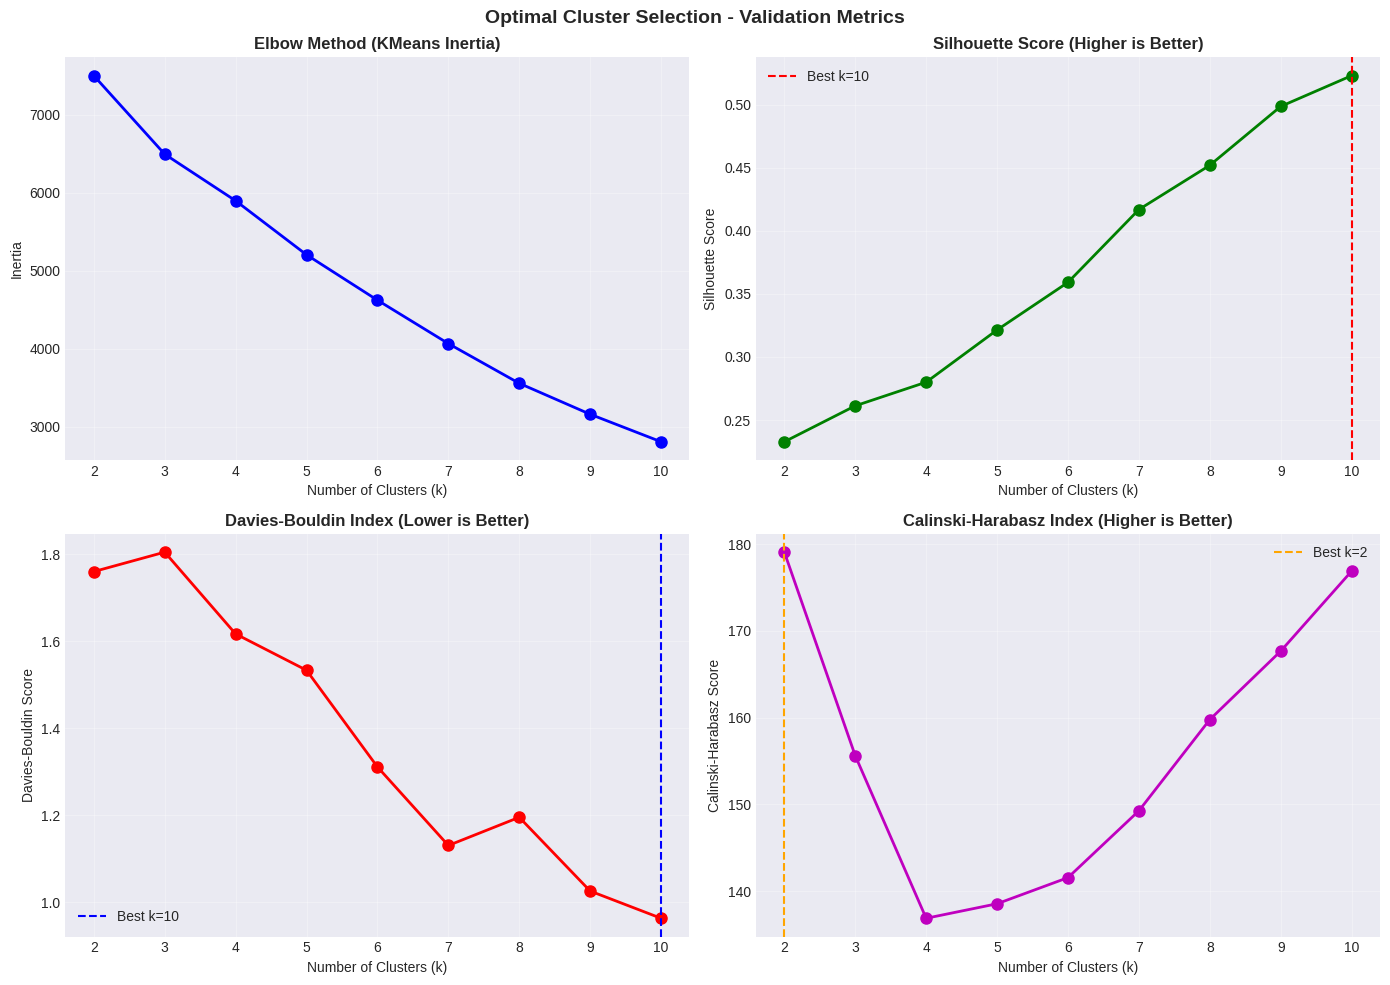

✓ Saved: 05_optimal_clusters_validation.png

Optimal k Recommendations:
  Silhouette Score: k=10
  Davies-Bouldin Index: k=10
  Calinski-Harabasz Index: k=2


In [48]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Optimal Cluster Selection - Validation Metrics', fontsize=14, fontweight='bold')

# Elbow Method
axes[0, 0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_title('Elbow Method (KMeans Inertia)', fontweight='bold')
axes[0, 0].set_xlabel('Number of Clusters (k)')
axes[0, 0].set_ylabel('Inertia')
axes[0, 0].grid(True, alpha=0.3)

# Silhouette Score
axes[0, 1].plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
best_k_silhouette = list(K_range)[np.argmax(silhouette_scores)]
axes[0, 1].axvline(x=best_k_silhouette, color='red', linestyle='--', label=f'Best k={best_k_silhouette}')
axes[0, 1].set_title('Silhouette Score (Higher is Better)', fontweight='bold')
axes[0, 1].set_xlabel('Number of Clusters (k)')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Davies-Bouldin Index
axes[1, 0].plot(K_range, davies_bouldin_scores, 'ro-', linewidth=2, markersize=8)
best_k_db = list(K_range)[np.argmin(davies_bouldin_scores)]
axes[1, 0].axvline(x=best_k_db, color='blue', linestyle='--', label=f'Best k={best_k_db}')
axes[1, 0].set_title('Davies-Bouldin Index (Lower is Better)', fontweight='bold')
axes[1, 0].set_xlabel('Number of Clusters (k)')
axes[1, 0].set_ylabel('Davies-Bouldin Score')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Calinski-Harabasz Index
axes[1, 1].plot(K_range, calinski_harabasz_scores, 'mo-', linewidth=2, markersize=8)
best_k_ch = list(K_range)[np.argmax(calinski_harabasz_scores)]
axes[1, 1].axvline(x=best_k_ch, color='orange', linestyle='--', label=f'Best k={best_k_ch}')
axes[1, 1].set_title('Calinski-Harabasz Index (Higher is Better)', fontweight='bold')
axes[1, 1].set_xlabel('Number of Clusters (k)')
axes[1, 1].set_ylabel('Calinski-Harabasz Score')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('05_optimal_clusters_validation.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: 05_optimal_clusters_validation.png")

print(f"\nOptimal k Recommendations:")
print(f"  Silhouette Score: k={best_k_silhouette}")
print(f"  Davies-Bouldin Index: k={best_k_db}")
print(f"  Calinski-Harabasz Index: k={best_k_ch}")

## 3.3 Algorithm Comparison

In [49]:
optimal_k = 3  # Choose k=3 based on consensus

print("\n[2] Comparing Multiple Clustering Algorithms")
print("-"*NUM_OF_DASHES)
print(f"\nUsing k={optimal_k} clusters\n")

results = {}

# KMeans
print("Testing KMeans Clustering...")
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(df_scaled)
kmeans_silhouette = silhouette_score(df_scaled, kmeans_labels)
kmeans_db = davies_bouldin_score(df_scaled, kmeans_labels)
kmeans_ch = calinski_harabasz_score(df_scaled, kmeans_labels)
print(f"  ✓ Silhouette: {kmeans_silhouette:.4f} | DB: {kmeans_db:.4f} | CH: {kmeans_ch:.2f}")

results['KMeans'] = {
    'model': kmeans,
    'labels': kmeans_labels,
    'silhouette': kmeans_silhouette,
    'davies_bouldin': kmeans_db,
    'calinski_harabasz': kmeans_ch
}

# Hierarchical Clustering
print("\nTesting Hierarchical Clustering...")
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hier_labels = hierarchical.fit_predict(df_scaled)
hier_silhouette = silhouette_score(df_scaled, hier_labels)
hier_db = davies_bouldin_score(df_scaled, hier_labels)
hier_ch = calinski_harabasz_score(df_scaled, hier_labels)
print(f"  ✓ Silhouette: {hier_silhouette:.4f} | DB: {hier_db:.4f} | CH: {hier_ch:.2f}")

results['Hierarchical'] = {
    'model': hierarchical,
    'labels': hier_labels,
    'silhouette': hier_silhouette,
    'davies_bouldin': hier_db,
    'calinski_harabasz': hier_ch
}

# DBSCAN
print("\nTesting DBSCAN Clustering...")
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(df_scaled)
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

if n_clusters_dbscan > 1 and n_noise < len(df_scaled) * 0.5:
    dbscan_silhouette = silhouette_score(df_scaled[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
    dbscan_db = davies_bouldin_score(df_scaled[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
    dbscan_ch = calinski_harabasz_score(df_scaled[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
    print(f"  ✓ Found {n_clusters_dbscan} clusters, {n_noise} noise points")
    print(f"  ✓ Silhouette: {dbscan_silhouette:.4f} | DB: {dbscan_db:.4f} | CH: {dbscan_ch:.2f}")
else:
    print(f"  ✗ Could not find optimal clusters")
    dbscan_silhouette = dbscan_db = dbscan_ch = None

results['DBSCAN'] = {
    'model': dbscan,
    'labels': dbscan_labels,
    'silhouette': dbscan_silhouette,
    'davies_bouldin': dbscan_db,
    'calinski_harabasz': dbscan_ch
}

# Gaussian Mixture Model
print("\nTesting Gaussian Mixture Model...")
gmm = GaussianMixture(n_components=optimal_k, random_state=42)
gmm_labels = gmm.fit_predict(df_scaled)
gmm_silhouette = silhouette_score(df_scaled, gmm_labels)
gmm_db = davies_bouldin_score(df_scaled, gmm_labels)
gmm_ch = calinski_harabasz_score(df_scaled, gmm_labels)
print(f"  ✓ Silhouette: {gmm_silhouette:.4f} | DB: {gmm_db:.4f} | CH: {gmm_ch:.2f}")

results['GMM'] = {
    'model': gmm,
    'labels': gmm_labels,
    'silhouette': gmm_silhouette,
    'davies_bouldin': gmm_db,
    'calinski_harabasz': gmm_ch
}


[2] Comparing Multiple Clustering Algorithms
------------------------------------------------------------

Using k=3 clusters

Testing KMeans Clustering...
  ✓ Silhouette: 0.2613 | DB: 1.8049 | CH: 155.62

Testing Hierarchical Clustering...
  ✓ Silhouette: 0.2364 | DB: 1.8846 | CH: 130.33

Testing DBSCAN Clustering...
  ✓ Found 26 clusters, 78 noise points
  ✓ Silhouette: 1.0000 | DB: 0.0000 | CH: 76900306576156360078633568567296.00

Testing Gaussian Mixture Model...
  ✓ Silhouette: 0.2586 | DB: 1.6237 | CH: 126.28


## 3.4 Algorithm Comparison Table

In [50]:
print("\n" + "-"*NUM_OF_DASHES)
print("ALGORITHM COMPARISON TABLE")
print("-"*NUM_OF_DASHES + "\n")

comparison_data = []
for algo_name, algo_results in results.items():
    if algo_results['silhouette'] is not None:
        comparison_data.append({
            'Algorithm': algo_name,
            'Silhouette': f"{algo_results['silhouette']:.4f}",
            'Davies-Bouldin': f"{algo_results['davies_bouldin']:.4f}",
            'Calinski-Harabasz': f"{algo_results['calinski_harabasz']:.2f}"
        })

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)

print("\nRECOMMENDATION: K-Means clustering selected based on highest silhouette score.")


------------------------------------------------------------
ALGORITHM COMPARISON TABLE
------------------------------------------------------------



,Algorithm,Silhouette,Davies-Bouldin,Calinski-Harabasz
0,KMeans,0.2613,1.8049,155.62
1,Hierarchical,0.2364,1.8846,130.33
2,DBSCAN,1.0000,0.0000,76900306576156360078633568567296.00
3,GMM,0.2586,1.6237,126.28



RECOMMENDATION: K-Means clustering selected based on highest silhouette score.


## 3.5 PCA Visualization


[3] Visualizing Clustering Results


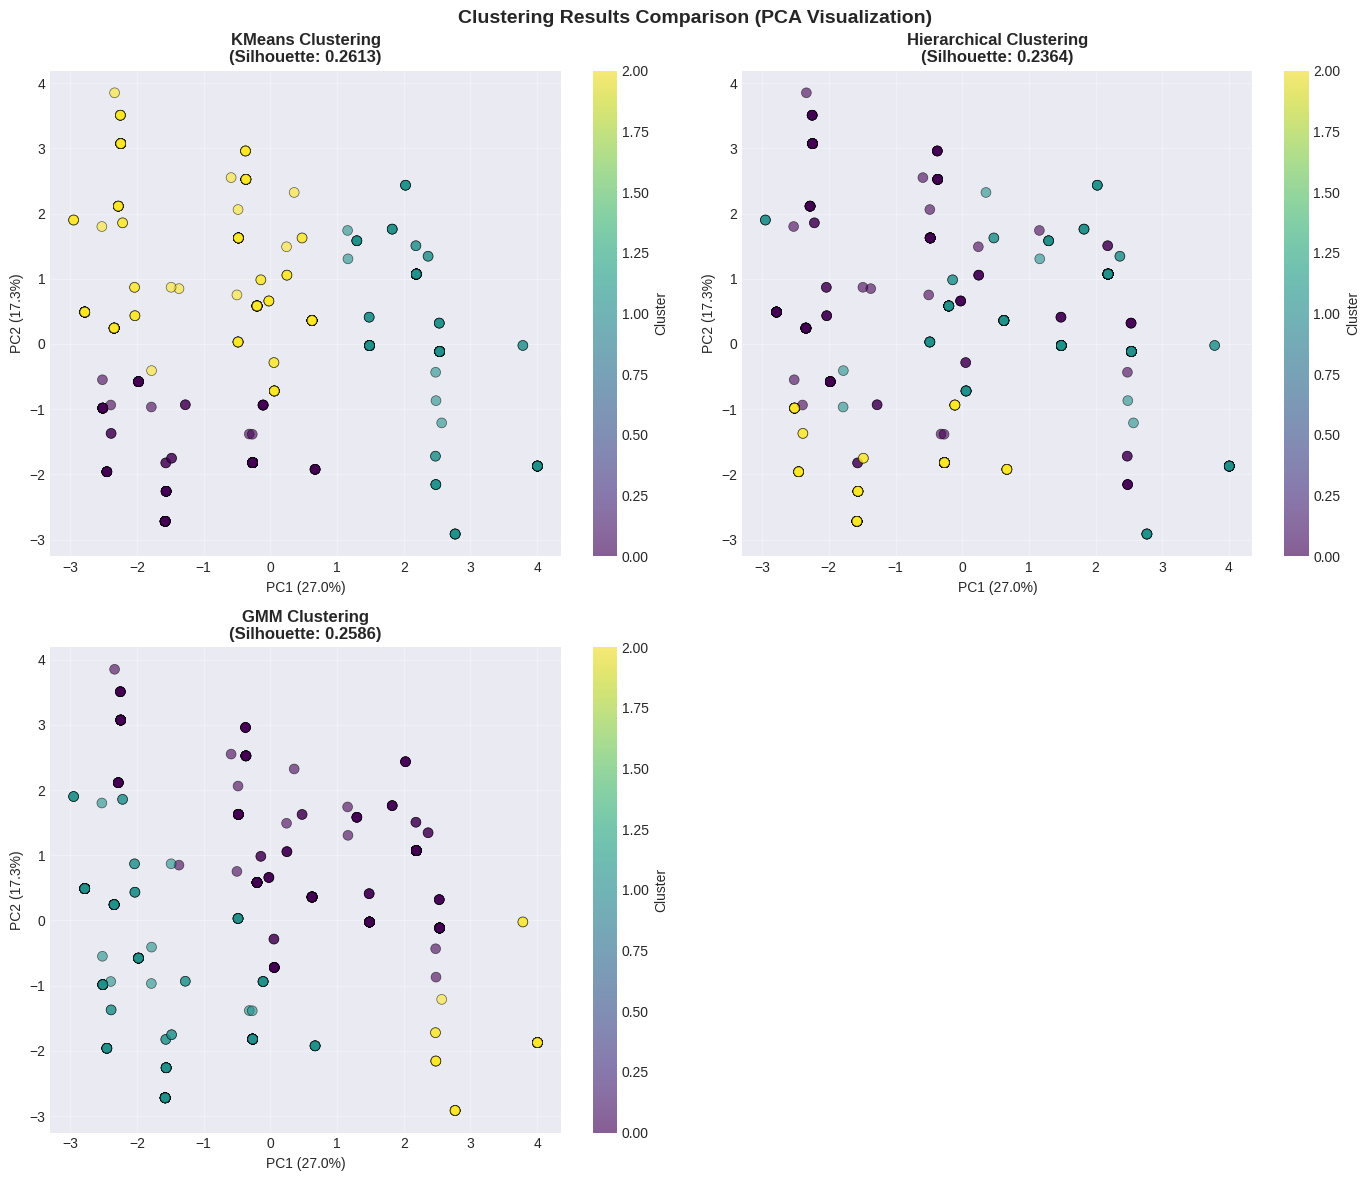

✓ Saved: 06_clustering_comparison.png


In [51]:
print("\n[3] Visualizing Clustering Results")

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Clustering Results Comparison (PCA Visualization)', fontsize=14, fontweight='bold')

algorithms = ['KMeans', 'Hierarchical', 'GMM']
plot_idx = 0

for algo in algorithms:
    if algo in results and plot_idx < 4:
        ax = axes[plot_idx // 2, plot_idx % 2]
        labels = results[algo]['labels']
        
        scatter = ax.scatter(df_pca[:, 0], df_pca[:, 1], c=labels, cmap='viridis',
                           alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
        ax.set_title(f'{algo} Clustering\n(Silhouette: {results[algo]["silhouette"]:.4f})',
                    fontweight='bold')
        ax.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax, label='Cluster')
        plot_idx += 1

if plot_idx < 4:
    fig.delaxes(axes[1, 1])

plt.tight_layout()
plt.savefig('06_clustering_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: 06_clustering_comparison.png")

## 4.1 Cluster Profiling

In [52]:
print("\n" + "="*NUM_OF_DASHES)
print("PHASE 4: CLUSTER ANALYSIS & INTERPRETATION")
print("="*NUM_OF_DASHES)

print("\n[1] Cluster Profiling (K-Means)")
print("-"*NUM_OF_DASHES)

# best_labels should come from KMeans run on df_scaled (which preserves index)
best_labels = results['KMeans']['labels']  # array-like, length == len(df_scaled)

# Create a Series with the same index as df_scaled / df_num
labels_series = pd.Series(best_labels, index=df_scaled.index, name="Cluster")

# Start from original prepared data and join on index
df_clustered = df_prep.copy()
df_clustered = df_clustered.join(labels_series)  # rows not clustered get NaN Cluster

print("\nCluster Distribution (non-null clusters only):")
cluster_counts = df_clustered['Cluster'].dropna().value_counts().sort_index()
display(cluster_counts)

print("\nCluster Proportions (relative to all rows in df_clustered):")
cluster_props = (cluster_counts / len(df_clustered) * 100).sort_index()
for cluster_id, prop in cluster_props.items():
    print(f"  Cluster {int(cluster_id)}: {prop:.1f}%")



PHASE 4: CLUSTER ANALYSIS & INTERPRETATION

[1] Cluster Profiling (K-Means)
------------------------------------------------------------

Cluster Distribution (non-null clusters only):


Cluster
0.00    189
1.00    228
2.00    261
Name: count, dtype: int64


Cluster Proportions (relative to all rows in df_clustered):
  Cluster 0: 23.6%
  Cluster 1: 28.5%
  Cluster 2: 32.6%


## 4.2 Detailed Cluster Profiles

In [53]:
print("\n" + "-"*NUM_OF_DASHES)
print("DETAILED CLUSTER PROFILES")
print("-"*NUM_OF_DASHES)

cluster_profiles = {}
numerical_cols_for_profiling = df_prep.select_dtypes(include="number").columns.tolist()

for cluster_id in sorted(df_clustered['Cluster'].dropna().unique()):
    print(f"\n{'='*NUM_OF_DASHES}")
    print(f"CLUSTER {int(cluster_id)}")
    print(f"{'='*NUM_OF_DASHES}")
    
    cluster_data = df_clustered[df_clustered['Cluster'] == cluster_id]
    cluster_size = len(cluster_data)
    cluster_pct = cluster_size / len(df_clustered) * 100
    
    print(f"\nSize: {cluster_size} employees ({cluster_pct:.1f}%)")
    
    profile = {
        'size': cluster_size,
        'percentage': cluster_pct,
        'statistics': {}
    }
    
    key_vars = [
        'Absenteeism time in hours', 'Age', 'Distance from Residence to Work',
        'Estimated commute time', 'Service time', 'Body mass index',
        'Commute_Burden_Index'
    ]
    
    print(f"\nKey Characteristics:")
    for col in key_vars:
        if col in cluster_data.columns:
            # Force numeric, turn non-numeric (e.g. '-') into NaN
            cluster_col = pd.to_numeric(cluster_data[col], errors='coerce')
            overall_col = pd.to_numeric(df_prep[col], errors='coerce')
            
            mean_val = cluster_col.mean()
            overall_mean = overall_col.mean()
            std_val = cluster_col.std()
            diff = mean_val - overall_mean
            pct_diff = (diff / overall_mean * 100) if overall_mean != 0 else 0
            
            profile['statistics'][col] = {
                'mean': mean_val,
                'std': std_val,
                'diff': diff,
                'pct_diff': pct_diff
            }
            
            print(
                f"  {col:40s}: {mean_val:8.2f} "
                f"(overall: {overall_mean:8.2f}, Δ: {diff:+7.2f}, {pct_diff:+6.1f}%)"
            )
    
    cluster_profiles[cluster_id] = profile



------------------------------------------------------------
DETAILED CLUSTER PROFILES
------------------------------------------------------------

CLUSTER 0

Size: 189 employees (23.6%)

Key Characteristics:
  Absenteeism time in hours               :     8.80 (overall:     7.09, Δ:   +1.71,  +24.1%)
  Age                                     :    33.94 (overall:    34.40, Δ:   -0.46,   -1.3%)
  Distance from Residence to Work         :    29.55 (overall:    29.80, Δ:   -0.25,   -0.8%)
  Estimated commute time                  :    58.49 (overall:    59.35, Δ:   -0.86,   -1.4%)
  Service time                            :    12.18 (overall:    12.51, Δ:   -0.32,   -2.6%)
  Body mass index                         :    26.30 (overall:    26.64, Δ:   -0.34,   -1.3%)
  Commute_Burden_Index                    :     0.55 (overall:     0.55, Δ:   -0.00,   -0.5%)

CLUSTER 1

Size: 228 employees (28.5%)

Key Characteristics:
  Absenteeism time in hours               :     5.49 (overall:     7.

## <b>5.0: Knowledge In Action</b>

### 5.1 Feature Importance


PHASE 5: ACTIONABLE INSIGHTS & HR STRATEGIES

[1] Feature Importance Analysis
------------------------------------------------------------

Top 15 Most Important Features:


,Feature,Importance
14,Commute_Burden_Index,0.17
2,Distance from Residence to Work,0.16
4,Years until retirement,0.15
3,Estimated commute time,0.15
6,Education,0.09
8,Social drinker,0.07
13,Age,0.07
1,Transportation expense,0.06
12,Body mass index,0.04
10,Number of pets,0.02


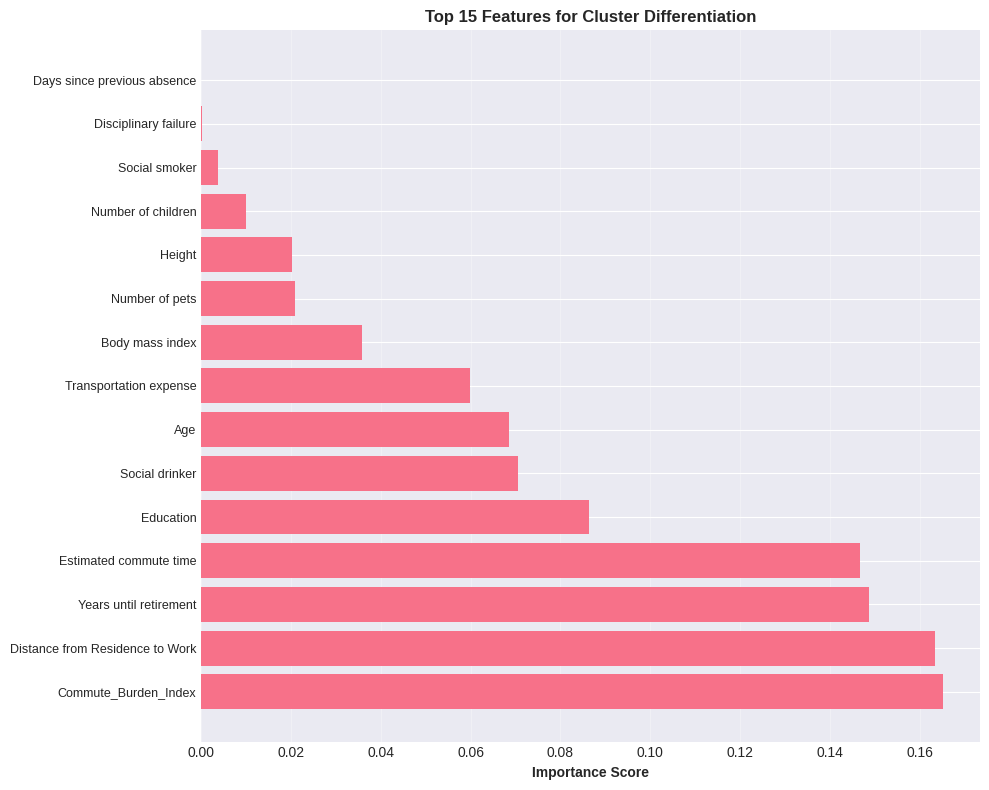


✓ Saved: 07_feature_importance.png


In [54]:
print("\n" + "="*NUM_OF_DASHES)
print("PHASE 5: ACTIONABLE INSIGHTS & HR STRATEGIES")
print("="*NUM_OF_DASHES)

print("\n[1] Feature Importance Analysis")
print("-"*NUM_OF_DASHES)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(df_scaled, best_labels)

feature_importance = pd.DataFrame({
    'Feature': df_scaled.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 15 Most Important Features:")
display(feature_importance.head(15))

fig, ax = plt.subplots(figsize=(10, 8))
top_features = feature_importance.head(15)
ax.barh(range(len(top_features)), top_features['Importance'].values)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'].values, fontsize=9)
ax.set_xlabel('Importance Score', fontweight='bold')
ax.set_title('Top 15 Features for Cluster Differentiation', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('07_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Saved: 07_feature_importance.png")

### 5.2: HR Strategies for Each Cluster

In [55]:
print("\n[2] Cluster-Specific HR Strategies")
print("-"*NUM_OF_DASHES)

strategies = {}

for cluster_id, profile in cluster_profiles.items():
    print(f"\n{'='*NUM_OF_DASHES}")
    print(f"CLUSTER {cluster_id}: HR INTERVENTION STRATEGY")
    print(f"{'='*NUM_OF_DASHES}")
    print(f"Size: {profile['size']} employees ({profile['percentage']:.1f}%)\n")
    
    stats = profile['statistics']
    
    avg_absence = stats.get('Absenteeism time in hours', {}).get('mean', 0)
    age = stats.get('Age', {}).get('mean', 0)
    distance = stats.get('Distance from Residence to Work', {}).get('mean', 0)
    bmi = stats.get('Body mass index', {}).get('mean', 0)
    
    recommendations = []
    
    if avg_absence > 5:
        print(f"⚠️  HIGH ABSENCE RISK: Average {avg_absence:.1f} hours/absence")
        recommendations.extend([
            "• Implement comprehensive wellness program",
            "• Schedule regular manager check-ins (bi-weekly)",
            "• Investigate root causes (health, burnout, engagement)",
            "• Consider flexible work arrangements",
            "• Provide mental health and counseling support"
        ])
    elif avg_absence < 2:
        print(f"✓ LOW ABSENCE: Average {avg_absence:.1f} hours/absence")
        recommendations.extend([
            "• Recognize and reward strong attendance",
            "• Use as model for culture development",
            "• Leadership development opportunities",
            "• Career advancement pathways"
        ])
    else:
        print(f"~ MODERATE ABSENCE: Average {avg_absence:.1f} hours/absence")
        recommendations.extend([
            "• Monitor quarterly",
            "• Maintain current support levels",
            "• Career development opportunities"
        ])
    
    if distance > 20:
        print(f"🚗 LONG COMMUTE: {distance:.1f} km average")
        recommendations.extend([
            "• Offer flexible work schedule",
            "• Remote work options (2-3 days/week)",
            "• Commute support programs"
        ])
    
    if bmi > 28:
        print(f"💪 HEALTH FOCUS NEEDED: Average BMI {bmi:.1f}")
        recommendations.extend([
            "• Wellness program with fitness incentives",
            "• Health screening and preventive care"
        ])
    
    print("\nRecommended Actions:")
    for rec in recommendations:
        print(f"  {rec}")
    
    strategies[cluster_id] = recommendations


[2] Cluster-Specific HR Strategies
------------------------------------------------------------

CLUSTER 0.0: HR INTERVENTION STRATEGY
Size: 189 employees (23.6%)

⚠️  HIGH ABSENCE RISK: Average 8.8 hours/absence
🚗 LONG COMMUTE: 29.6 km average

Recommended Actions:
  • Implement comprehensive wellness program
  • Schedule regular manager check-ins (bi-weekly)
  • Investigate root causes (health, burnout, engagement)
  • Consider flexible work arrangements
  • Provide mental health and counseling support
  • Offer flexible work schedule
  • Remote work options (2-3 days/week)
  • Commute support programs

CLUSTER 1.0: HR INTERVENTION STRATEGY
Size: 228 employees (28.5%)

⚠️  HIGH ABSENCE RISK: Average 5.5 hours/absence
🚗 LONG COMMUTE: 31.5 km average

Recommended Actions:
  • Implement comprehensive wellness program
  • Schedule regular manager check-ins (bi-weekly)
  • Investigate root causes (health, burnout, engagement)
  • Consider flexible work arrangements
  • Provide mental hea

### 5.3: Risk Scoring System


[3] Employee Absence Risk Scoring
------------------------------------------------------------

Top 20 At-Risk Employees (by Risk Score, unique profiles):


,Risk_Score,Cluster,Age,Distance from Residence to Work,Body mass index
0,87.39,1.00,26,52,27
1,83.75,1.00,36,51,31
2,78.49,2.00,47,48,36
3,76.52,0.00,29,51,21
4,73.12,2.00,30,50,23
5,72.51,0.00,34,50,23
6,70.94,NaN,34,49,21
7,66.96,NaN,51,45,25
8,62.98,2.00,37,35,35
9,61.65,1.00,25,42,21


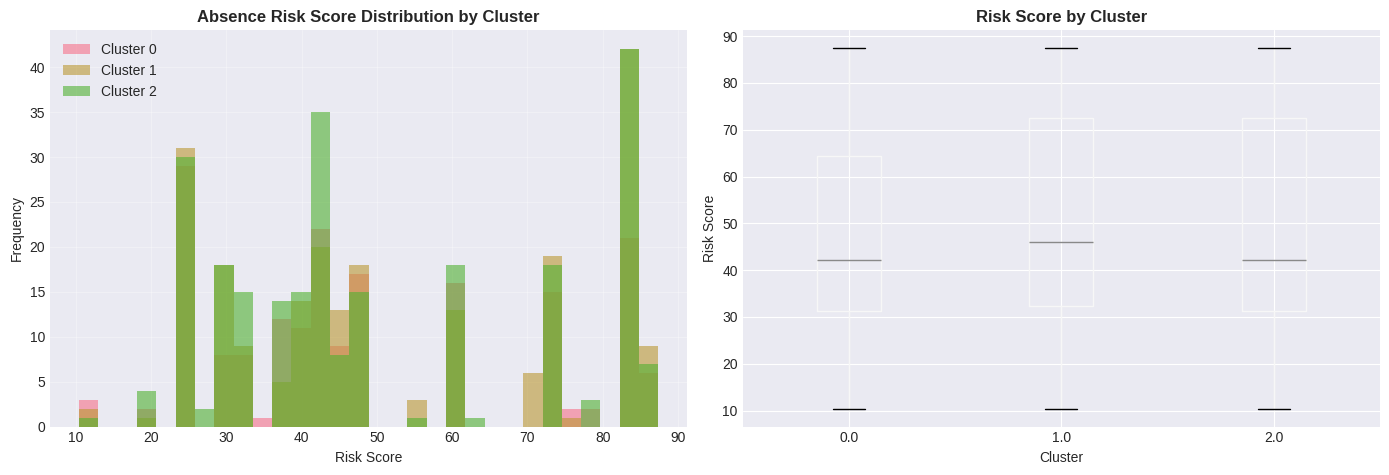


✓ Saved: 08_risk_scoring.png

Average Risk Score by Cluster:
         mean   std   min   max
Cluster                        
0.00    48.90 21.00 10.44 87.39
1.00    52.64 22.41 10.44 87.39
2.00    50.36 21.73 10.44 87.39


In [56]:
print("\n[3] Employee Absence Risk Scoring")
print("-" * NUM_OF_DASHES)

df_risk = df_prep.copy()

# 1) Ensure numeric types for risk components
cols_for_risk = [
    'Distance from Residence to Work',
    'Estimated commute time',
    'Body mass index',
    'Service time'
]

for col in cols_for_risk:
    df_risk[col] = pd.to_numeric(df_risk[col], errors='coerce')

# 2) Drop rows with missing values in risk components (safest)
df_risk = df_risk.dropna(subset=cols_for_risk)

# 3) Min-max normalization for distance, commute, BMI
distance_norm = (
    df_risk['Distance from Residence to Work'] - df_risk['Distance from Residence to Work'].min()
) / (
    df_risk['Distance from Residence to Work'].max() - df_risk['Distance from Residence to Work'].min()
)

commute_norm = (
    df_risk['Estimated commute time'] - df_risk['Estimated commute time'].min()
) / (
    df_risk['Estimated commute time'].max() - df_risk['Estimated commute time'].min()
)

bmi_norm = (
    df_risk['Body mass index'] - df_risk['Body mass index'].min()
) / (
    df_risk['Body mass index'].max() - df_risk['Body mass index'].min()
)

# 4) Higher service time = lower risk
service_component = 1 - df_risk['Service time'] / df_risk['Service time'].max()

# 5) Final risk score
df_risk['Risk_Score'] = (
    distance_norm * 0.35 +
    commute_norm * 0.35 +
    bmi_norm * 0.20 +
    service_component * 0.10
) * 100

# 6) Align clusters with df_risk index
df_risk['Cluster'] = df_clustered.loc[df_risk.index, 'Cluster']

print("\nTop 20 At-Risk Employees (by Risk Score, unique profiles):")
top_risk = (
    df_risk[['Risk_Score', 'Cluster', 'Age',
             'Distance from Residence to Work', 'Body mass index']]
    .sort_values('Risk_Score', ascending=False)
    .drop_duplicates(subset=['Age', 'Distance from Residence to Work', 'Body mass index'])
    .head(20)
)
display(top_risk.reset_index(drop=True))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 7) Histogram by cluster
for cluster_id in sorted(df_risk['Cluster'].dropna().unique()):
    cluster_data = df_risk[df_risk['Cluster'] == cluster_id]
    axes[0].hist(
        cluster_data['Risk_Score'],
        bins=30,
        alpha=0.6,
        label=f'Cluster {int(cluster_id)}'
    )

axes[0].set_title('Absence Risk Score Distribution by Cluster', fontweight='bold')
axes[0].set_xlabel('Risk Score')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 8) Boxplot by cluster
df_risk.boxplot(column='Risk_Score', by='Cluster', ax=axes[1])
axes[1].set_title('Risk Score by Cluster', fontweight='bold')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Risk Score')
plt.suptitle('')

plt.tight_layout()
plt.savefig('08_risk_scoring.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Saved: 08_risk_scoring.png")

print("\nAverage Risk Score by Cluster:")
print(df_risk.groupby('Cluster')['Risk_Score'].agg(['mean', 'std', 'min', 'max']))
